In [153]:
import praw
from secrets import *
import pandas as pd
import spacy
from spacy.matcher import Matcher
nlp=spacy.load('en_core_web_sm')

In [154]:
# I import these from secrets, but you should use your own
reddit = praw.Reddit(client_id=CLIENT_ID,
                     client_secret=CLIENT_SECRET,
                     user_agent = USER_AGENT)

Now let's write a function to help us get the comments from each post 

In [155]:
def get_all_comments(praw_submission, verbose=False):
    """more info on how to work with comments can be found here: https://praw.readthedocs.io/en/latest/tutorials/comments.html"""
    if verbose:
        print("getting comments for", praw_submission.title)
    praw_submission.comments.replace_more(limit=None)
    return pd.DataFrame([ vars(c) for c in praw_submission.comments.list()])
    

Now we'll create a convienece function to create spacy documents as well as add some basic nlp stat columns

In [156]:
def add_nlp(df):
    df['doc'] = df.body.apply(nlp)
    df['num_tokens'] = df.doc.apply(len)
    df['num_sent'] = df.doc.apply(lambda doc: len(list(doc.sents)))
    return df

Let's get those posts and comments

In [157]:
gw = reddit.subreddit('gonewild')

In [158]:
%%time
comment_df = pd.concat([ get_all_comments(p) for p in gw.new(limit=1000) ])
# this took me about 4 minutes on my machine

CPU times: user 18.7 s, sys: 483 ms, total: 19.2 s
Wall time: 3min 49s


In [171]:
comment_df.shape

(5921, 71)

In [159]:
corpus = ' '.join(comment_df.body)

In [160]:
doc = nlp(corpus.lower())

In [161]:
len(doc)

52117

In [181]:
# let's get rid of common stopwords, punctuations and emojis
# stuff the words into one string
clean_doc = [ w.lemma_ for w in doc if w.is_stop == False and w.is_alpha]
print(len(clean_doc))
clean_doc = ' '.join([ w.lemma_ for w in doc if w.is_stop == False and w.is_alpha])

18504


In [179]:
# my warper around the WordCloud class from wordcloud
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from wordcloud import WordCloud, ImageColorGenerator

def create_word_cloud(final_data):
    # initiate WordCloud object with parameters width, height, maximum font size and background color
    # call the generate method of WordCloud class to generate an image

    # let's make things a little sexier by using a breast silohette as the mask
    mask = np.array(Image.open("boob sil.jpg")) 
    wordcloud = WordCloud(width=1600, height=800, 
                          max_font_size=200, background_color="white",
                          mask=mask, 
                          contour_width=20, contour_color="lightgrey").generate(final_data)
    
    image_colors = ImageColorGenerator(mask)
    wordcloud.recolor(color_func=image_colors)
    # plt the image generated by WordCloud class
    plt.figure(figsize=(20,15))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.tight_layout()
    plt.savefig('wordcloud_gonewild.png')
    plt.show()

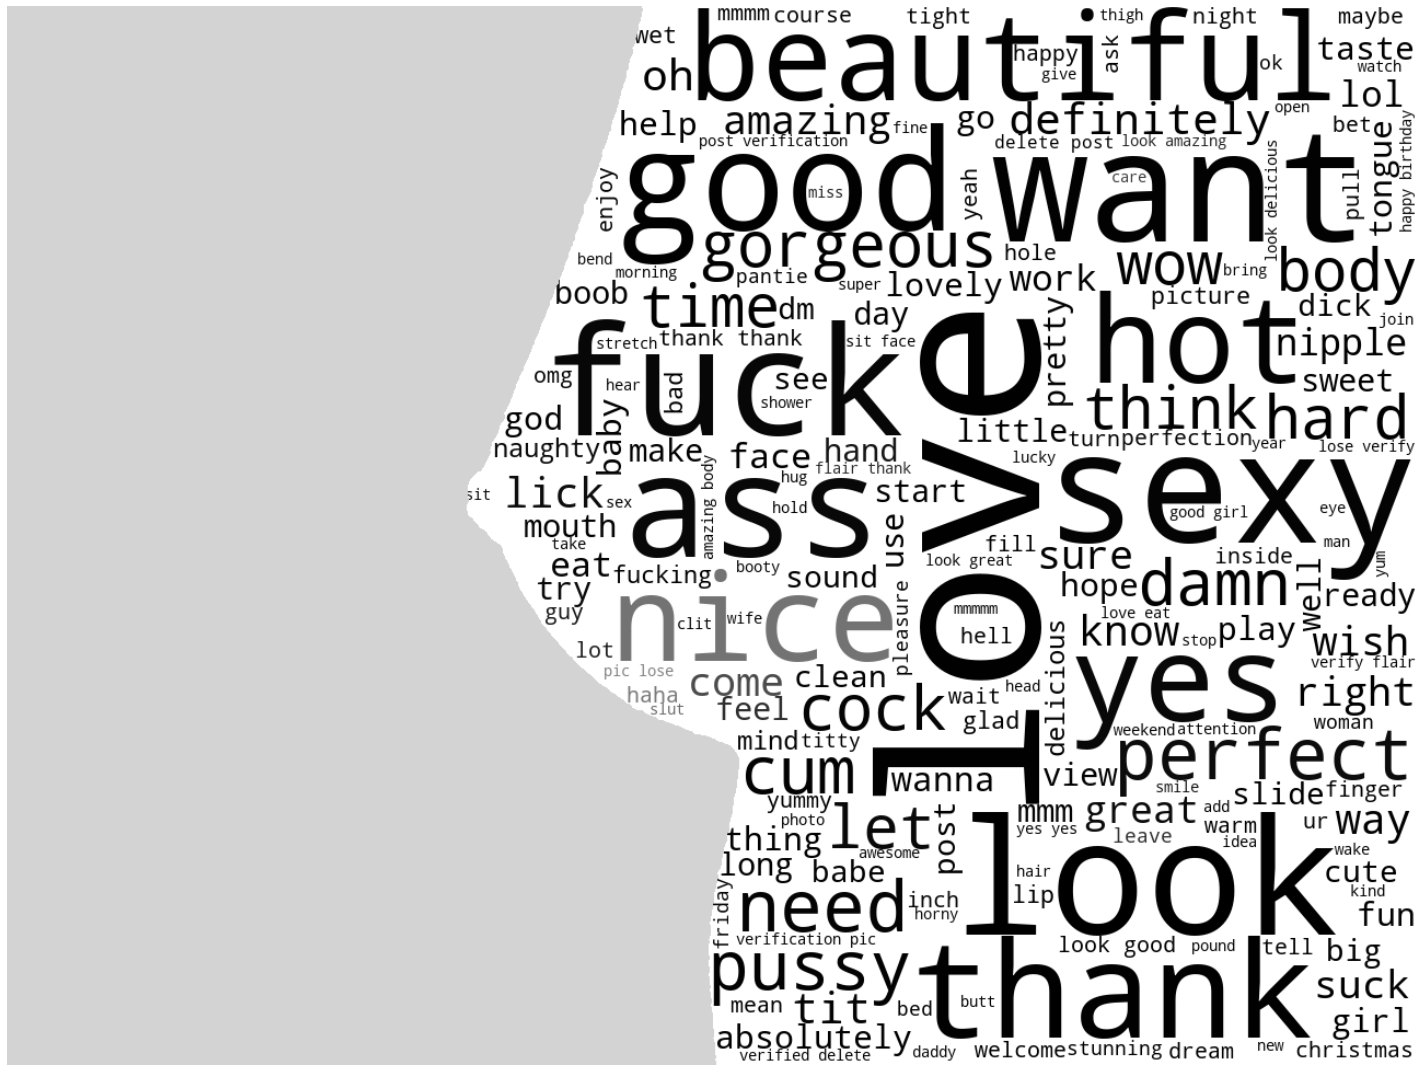

In [180]:
create_word_cloud(clean_doc)